# Process and visualize the kriging interpolation results

The kriging interpolation results for global dust deposition rates are taken from [Dust fluxes and iron fertilization in Holocene and Last Glacial Maximum climates, Geophysical Review Letters](https://doi.org/10.1002/2015GL064250). This notebook visualizes the results and analyzes its log-normal fit.

## Preliminaries

Import the necessary libraries and specify the data folders.

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm, lognorm
import xarray as xr
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [144]:
import warnings
warnings.filterwarnings("ignore")

In [145]:
FIGURE_PATH = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Code/figures/"
DATA_PATH = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/"
DATA_LOAD_PATH = DATA_PATH + "original_data/"
DATA_SAVE_PATH = DATA_PATH + "processed_data/"

In [155]:
path_to_shapefile ="C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/ne_110m_admin_0_countries.shp"
world = gpd.read_file(path_to_shapefile)

## Processing functionality

The processing of the data involves standard normalization.

In [147]:
class Preprocess:
    def __init__(self, df, time_label=None):
        '''
        Create a preprocess class for the given dataframe.
        The time label correspond to the climate period
        with the label 1 corresponding to the Holocene and
        the label 2 to the Last Glacial Maximum.

        '''
        self.df = df.copy()
        self.time = time_label

    def preprocess_kriging(self):
        '''Clean up the dataset of kriging interpolation.'''
        # Select the correct period
        self.df.reset_index(inplace=True)
        self.df = self.df.groupby(['period', 'lat', 'lon']).mean()
        self.df.reset_index(inplace=True)
        self.df = self.df[self.df['period'] == self.time]
        # rename data headers
        self.df.rename(columns={"Flux": "dep"}, inplace=True)
        # Convert data from kg/m^2/s to g/m^2/a
        self.df["dep"] = self.df["dep"].values * 1000 * 365 * 24 * 60 * 60
        # Change longitude range to (-180, 180)
        self.df.loc[self.df['lon'] > 180, 'lon'] = self.df['lon'] - 360

    def normalize_data(self):
        '''Normalize data based on z-score.'''
        self.df['log_dep'] = np.log10(self.df['dep'])
        self.df['log_dep_norm'] = StandardScaler().fit_transform(np.array(self.df['log_dep']).reshape(-1, 1))


Load visualization functions to generate the figures.

In [148]:
with open("functions_plot.py", 'r') as file:
    content = file.read()

# Execute the content of the .py file
exec(content)

## Preprocess the datasets

Load the datasets from [Dust fluxes and iron fertilization in Holocene and Last Glacial Maximum climates, PANGAEA](https://doi.pangaea.de/10.1594/PANGAEA.847983).

The logarithm of the dust deposition values are normalized based on the $z$-scores.

In [149]:
url_search = "https://doi.pangaea.de/10.1594/PANGAEA.847983"

# get the html code
response = requests.get(url_search)
soup = BeautifulSoup(response.text)

# Find the anchor tag with the download link
download_link = soup.find('a', id='static-download-link')

# Extract the URL from the href attribute
url = download_link['href']

# Send a GET request to the URL
response = requests.get(url)

df_kriging_raw = xr.open_dataset(response.content).to_dataframe()

In [150]:
preprocessor_kriging_Holocene = Preprocess(df_kriging_raw, 1)
preprocessor_kriging_Holocene.preprocess_kriging()
preprocessor_kriging_Holocene.normalize_data()
df_kriging_Holocene = preprocessor_kriging_Holocene.df

preprocessor_kriging_LGM = Preprocess(df_kriging_raw, 2)
preprocessor_kriging_LGM.preprocess_kriging()
preprocessor_kriging_LGM.normalize_data()
df_kriging_LGM = preprocessor_kriging_LGM.df
print("Shape Holocene:", df_kriging_Holocene.shape)
print("Missing values Holocene:\n", df_kriging_Holocene[['lat', 'lon', 'log_dep']].isna().sum())
print("Preview Holocene:\n", df_kriging_Holocene[['lat', 'lon', 'log_dep']].dropna().head())

Shape Holocene: (8192, 7)
Missing values Holocene:
 lat        0
lon        0
log_dep    0
dtype: int64
Preview Holocene:
        lat      lon   log_dep
0 -87.8638   0.0000 -3.220816
1 -87.8638   2.8125 -3.228133
2 -87.8638   5.6250 -3.228456
3 -87.8638   8.4375 -3.242660
4 -87.8638  11.2500 -3.244719


## Visualise the datasets

Plot the dust deposition rate of the kriging interpolation at locations on the global grid. Also, plot a log-normal fit of the kriging interpolation.

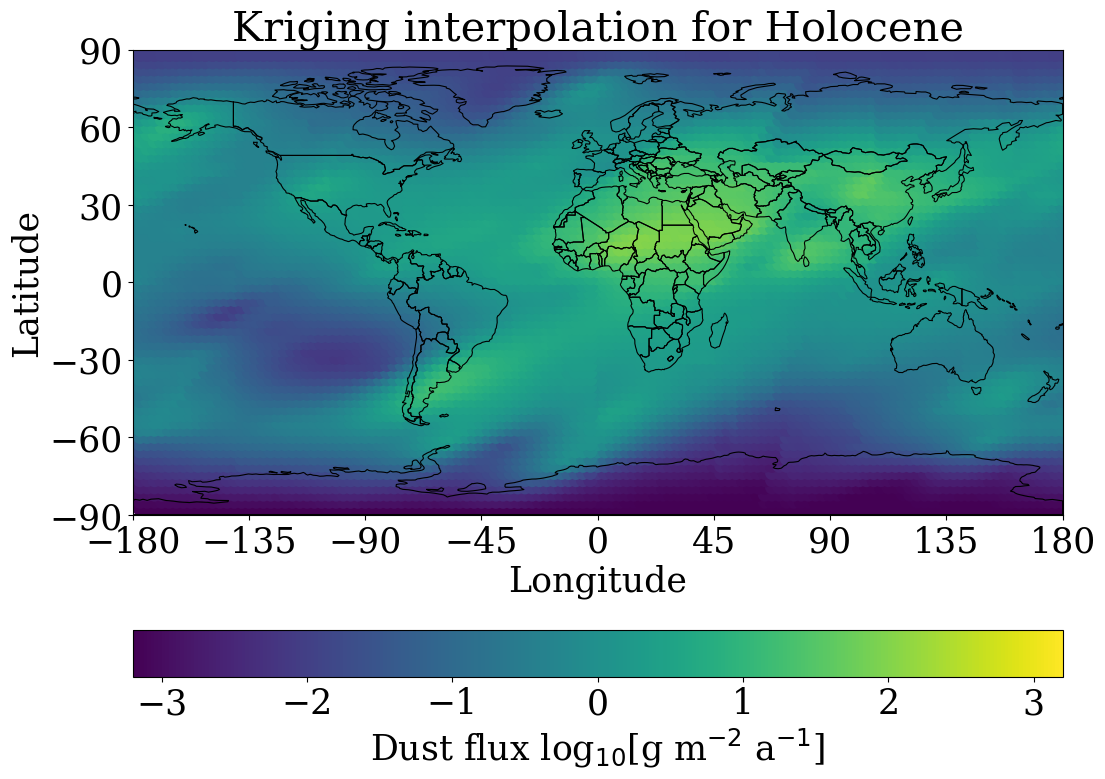

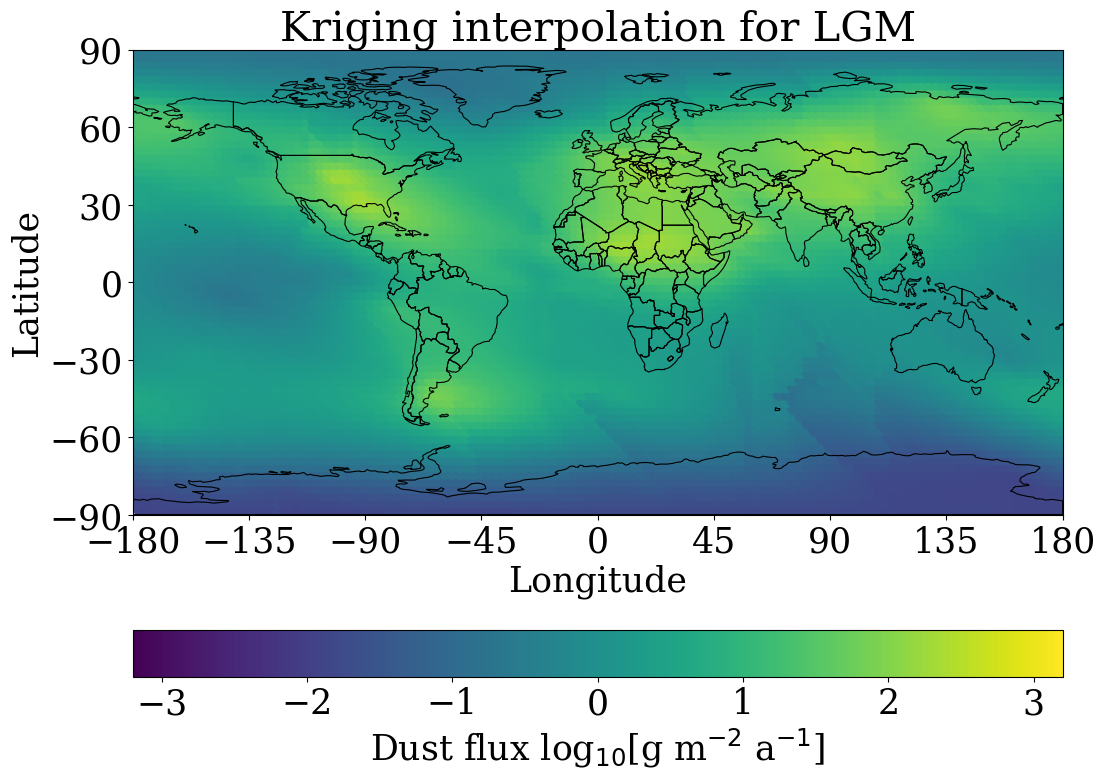

In [151]:
plot_dust_deposition_map(df=df_kriging_Holocene,
                         title='Kriging interpolation for Holocene',
                         name_to_save='KRIGING_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_kriging_LGM,
                         title='Kriging interpolation for LGM',
                         name_to_save='KRIGING_MAP_LGM')

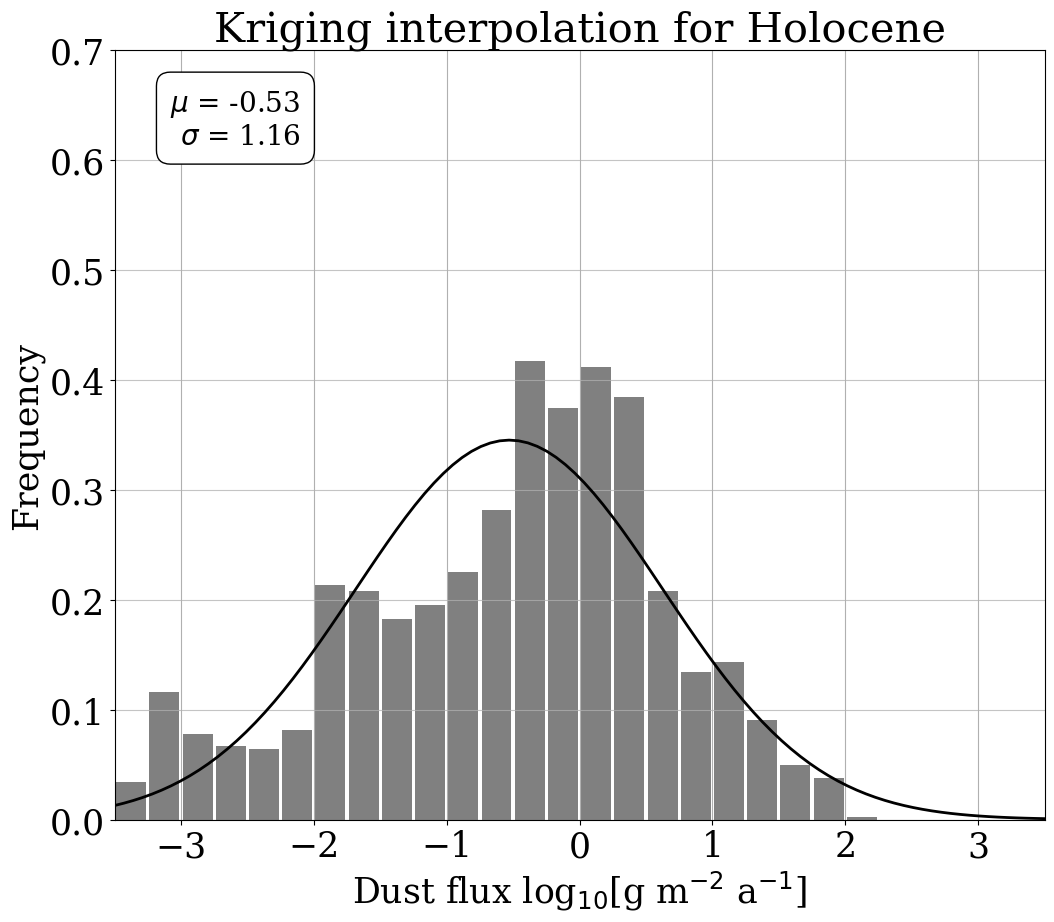

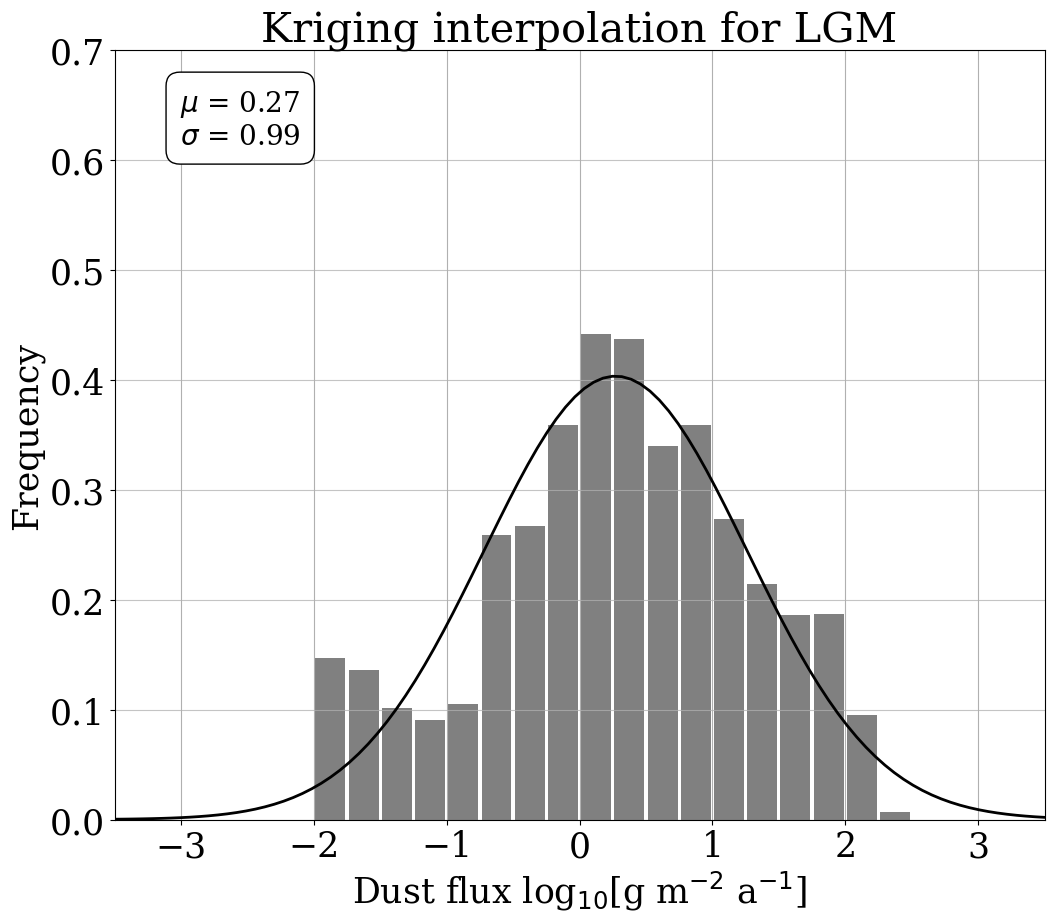

In [152]:
plot_hist(df=df_kriging_Holocene,
          title='Kriging interpolation for Holocene',
          name_to_save='KRIGING_HIST_HOLOCENE')

plot_hist(df=df_kriging_LGM,
          title='Kriging interpolation for LGM',
          name_to_save='KRIGING_HIST_LGM')

## Export the processed data

In [153]:
with open(DATA_SAVE_PATH + 'df_kriging_Holocene.csv', 'w') as f:
    df_kriging_Holocene.to_csv(f, index=False)

with open(DATA_SAVE_PATH + 'df_kriging_LGM.csv', 'w') as f:
    df_kriging_LGM.to_csv(f, index=False)